# Pulses Of Light
## Introduction
We have already had a look at how constant E field interact with a three level atom showing the susceptability, $\chi$, and *slow light*. Now we will look at how pulses of the probe beam interact with the atom and end up at *pulse distortion*. 
## Imports

In [11]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
from scipy.optimize import curve_fit
from scipy.constants import c, e, hbar
from qutip import *
import matplotlib.patches as mpatches
from scipy import signal
from arc import *
from scipy.fft import fft, ifft, fftfreq

%matplotlib inline

# Setting up Rydberg Atom

In [3]:
rabi_probe = 1E-6
rabi_couple = 0.1
detune_probe = 0
detune_couple = 0
gamma_b = 1
gamma_c = 1E-6

freq = 10* rabi_probe
wave_vec = 2*np.pi/freq

atom = Rubidium(preferQuantumDefects =False)
level = atom.getEnergy(atom.groundStateN,1,0.5)-atom.getEnergy(atom.groundStateN,0,0.5)
omega_eg = level*e/hbar


#signal params
tau = 10E-6
slope = tau*2
gradient = rabi_probe/slope

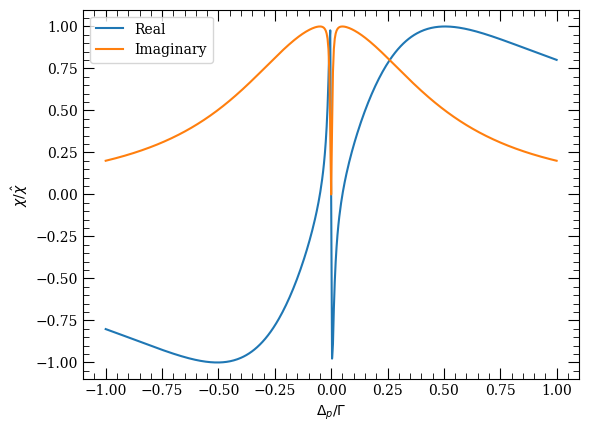

In [4]:
detuning_eg = np.linspace(-1,1,501)
psi0 = (basis(3,0)*2+basis(3, 1)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3]),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4]]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]
real = []
imag=[]
chi = []

for detune in detuning_eg:
    H = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,rabi_couple],[0,rabi_couple,-2*(detune-detune_couple)]]))
    # H2 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,1E-6],[0,1E-6,-2*(detune-detune_couple)]]))
    result = steadystate(H, c_ops)
    chi.append(result[0,1])
    real.append(result[0,1].real)
    imag.append(result[0,1].imag)

plt.plot(detuning_eg/gamma_b, real/max(real), label = 'Real')
plt.plot(detuning_eg/gamma_b, imag/max(imag), label = 'Imaginary')
plt.legend()
plt.xlabel('$\Delta_p/\Gamma$')
plt.ylabel('$\chi/\hat{\chi}$')

# if save:
#     plt.savefig(str("probe-"+str(rabi_probe)+"_"+str(detune_probe)+"_couple-"+str(rabi_couple)+"_"+str(detune_couple)+"_gamma(b_c)-"+str(gamma_b)+"_"+str(gamma_c)+".svg"))
#     # plt.savefig("plot.svg")

plt.show()

## Making the Pulse
We will start with a Gaussian pulse

# Gaussian

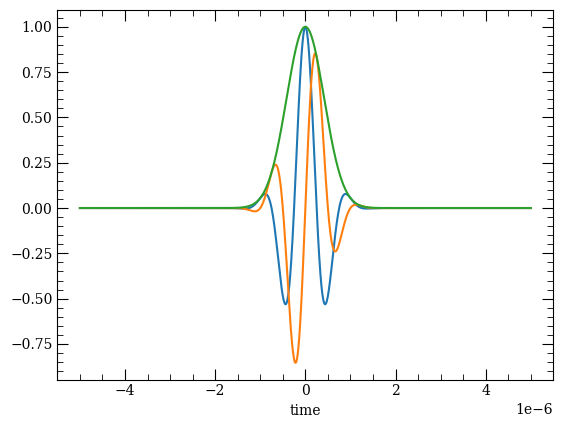

In [68]:
N = 1000
T = 1E-5

times = np.linspace(-T/2,T/2,N)

gaus_sig,imag_gaus,y_env = signal.gausspulse(times,fc = 1E6, bw = 0.9,retquad=True,retenv=True)
freq = fft(gaus_sig)

plt.plot(times,gaus_sig)
plt.plot(times,imag_gaus)
plt.plot(times,y_env)
plt.xlabel("time")
plt.show()

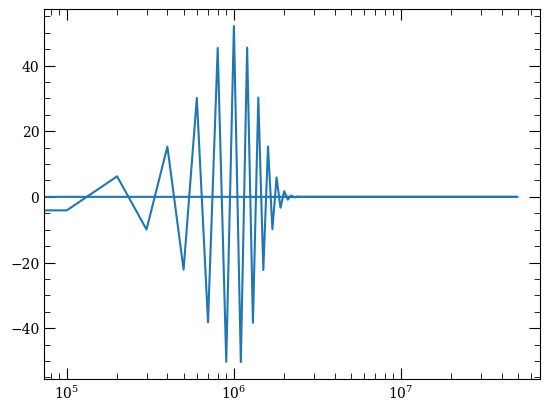

In [69]:
freq = np.fft.fftfreq(N,T/N)
yf = fft(gaus_sig)

plt.xscale('log')
plt.plot(freq,yf)


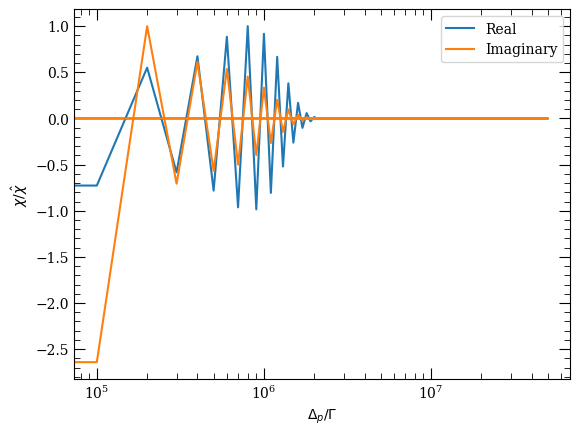

In [70]:
chi = []
real = []
imag= []


for i in range(len(freq)):
    H = 0.5*Qobj(np.array([[0,yf[i],0],[yf[i],-2*freq[i],rabi_couple],[0,rabi_couple,-2*(freq[i]-detune_couple)]]))
    # H2 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune,1E-6],[0,1E-6,-2*(detune-detune_couple)]]))
    result = steadystate(H, c_ops)
    chi.append(result[0,1])
    real.append(result[0,1].real)
    imag.append(result[0,1].imag)

plt.plot(freq/gamma_b, real/max(real), label = 'Real')
plt.plot(freq/gamma_b, imag/max(imag), label = 'Imaginary')
plt.legend()
plt.xlabel('$\Delta_p/\Gamma$')
plt.ylabel('$\chi/\hat{\chi}$')

# if save:
#     plt.savefig(str("probe-"+str(rabi_probe)+"_"+str(detune_probe)+"_couple-"+str(rabi_couple)+"_"+str(detune_couple)+"_gamma(b_c)-"+str(gamma_b)+"_"+str(gamma_c)+".svg"))
#     # plt.savefig("plot.svg")
plt.xscale('log')
plt.show()

# Dispersion
Related to the wavevector, $k$, and high orders of it.


$$
1+\chi = n^2 = (c/v)^2 = \frac{c^2}{\omega^2}k^2
$$

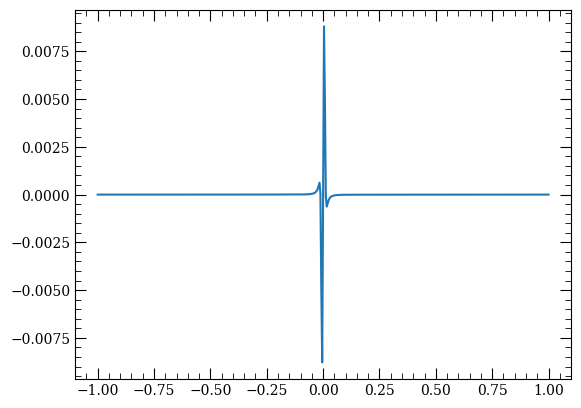

In [52]:
real = np.array(real)
imag = np.array(imag)
chi = np.array(chi)

dchi = np.gradient(real, detuning_eg/gamma_b)
d2chi = np.gradient(dchi,detuning_eg/gamma_b)

denom = 1+real/2+(omega_eg-detuning_eg)*dchi/2
# plt.plot(detuning_eg, denom)
v_g = c/denom
k_2 = (d2chi*(1+chi)**-0.5)/2-(dchi*(1+chi)**-1.5)/4

plt.plot(detuning_eg, k_2.real)
# plt.plot(detuning_eg, k_2.imag)

In [ ]:
z=1

sigma = (t_0**2 + ((k_2*z)/t_0)**2)**0.5



# Dispersion

In [ ]:
t_0 = 1.2

(t_0**2 + ((k_2*z)/t_0)**2)**0.5

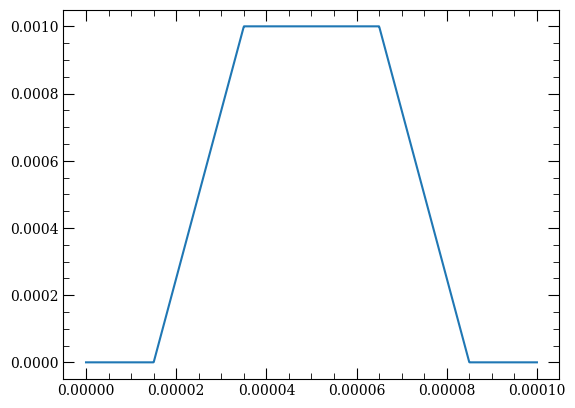

In [141]:


def trapzoid_signal(t, args):
    slope = args['slope']
    amp = args['A']
    width = args['width']
    offs = args['offs']
    a = slope*width*signal.sawtooth(2*np.pi*t/width, width=0.5)/4
    a[a>amp/2.] = amp/2.
    a[a<-amp/2.] = -amp/2.
    return a + amp/2. + offs

def get_trap(t,args):
    times = np.linspace(0,1E-4,1000)
    trap = trapzoid_signal(times,args)
    index = np.where(times == t)
    return trap[index]

args = {'A': rabi_probe, 'slope': gradient, 'width': 1E-4, 'offs': 0}
plt.plot(times,trapzoid_signal(times,args))

Using this pulse, the rabi frequencies, which are proportional to the strength of E field, $\epsilon$, can be modified in the existing Hamiltonian
$$
H = \frac{\hbar}{2}
\begin{pmatrix}
0 & \Omega_p \times \epsilon & 0\\
\Omega_p \times \epsilon & -2\Delta_p & \Omega_c\\
0 & \Omega_c & -2(\Delta_p-\Delta_c)
\end{pmatrix}$$

In [142]:
H0 = 0.5*Qobj(np.array([[0,rabi_probe,0],[rabi_probe,-2*detune_probe,rabi_couple],[0,rabi_couple,-2*(detune_probe-detune_couple)]]))
H1 = 0.5*Qobj(np.array([[0,1,0],[1,0,0],[0,0,0]]))
H = [H0, [H1, get_trap]]
psi0 = (basis(3,0)).unit()
c_ops = [np.sqrt(gamma_b)*(qutip.three_level_atom.three_level_ops()[3].dag()),np.sqrt(gamma_c)*qutip.three_level_atom.three_level_ops()[4].dag()]
e_ops = [np.sqrt(2)*jmat(1,'x'),np.sqrt(2)*jmat(1,'y'),2*jmat(1,'z')-1]


In [143]:
args['width']

0.0001

In [144]:
args = {'A': rabi_probe, 'slope': gradient, 'width': 1E-4, 'offs': 0}

result_me = mesolve(H, psi0, times, c_ops, e_ops, args=args)


TypeError: only length-1 arrays can be converted to Python scalars

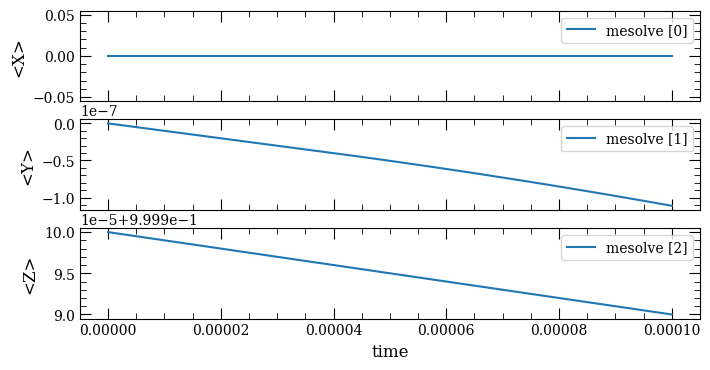

In [145]:
plot_expectation_values(
    [result_me], ylabels=["<X>", "<Y>", "<Z>"], show_legend=True
);